### 10장 회귀 분석으로 연속적 타깃 변수 예측
- 10.1 선형 회귀
- 10.2 주택 데이터셋 탐색
- 10.3 최소 제곱 선형 회귀 모델 구현
- 10.4 RANSAC을 사용하여 안정된 회귀 모델 훈련
- 10.5 선형 회귀 모델의 성능 평가
- 10.6 회귀에 규제 적용
- 10.7 선형 회귀 모델을 다항 회귀로 변환
- 10.8 랜덤 포레스트를 사용하여 비선형 관계 다루기
--- 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
## Boston House Price dataset 
## 구분자가 하나 이상의 공백으로 이루어짐 --> sep = '\s+'
df = pd.read_csv('data/housing.data.txt', header = None, sep = '\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


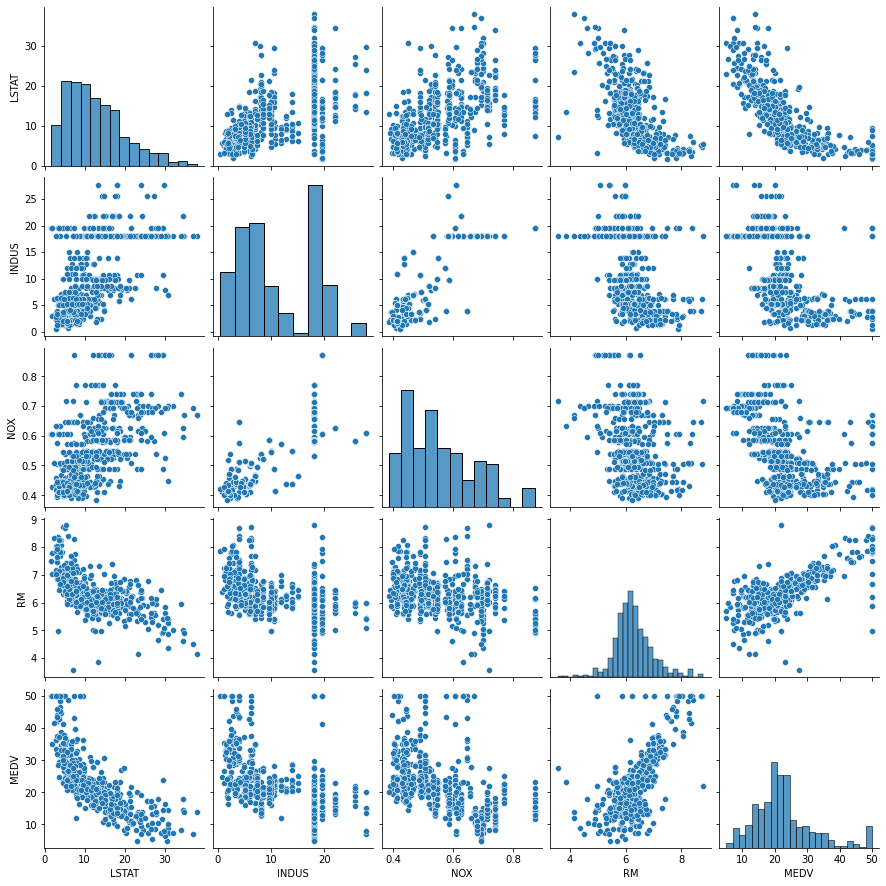

In [3]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols])

- MEDV(주택가격)과 상관관계가 보이는 변수 : LSTAT(저소득 계층 비율), RM(방 갯수)

<AxesSubplot:>

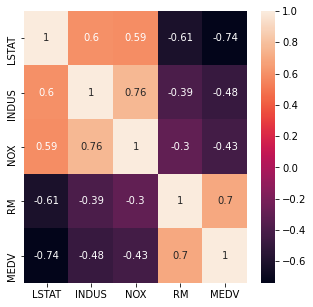

In [4]:
plt.figure(figsize=(5, 5)) 
sns.heatmap(df[cols].corr(), annot=True)

---
#### 1. Sklearn으로 회귀모델 가중치 추정
- 주택가격(MEDV)와 방갯수(RM)과의 회귀방정식 
---

In [15]:
X = df[['RM']]  ## 회귀분석을 위해 1차원 배열로 변경 
y = df['MEDV']

from sklearn.linear_model import LinearRegression 
slr = LinearRegression()
slr.fit(X, y)

print('절편 =' , slr.intercept_)
print('기울기 =' , slr.coef_[0])

절편 = -34.670620776438554
기울기 = 9.102108981180308


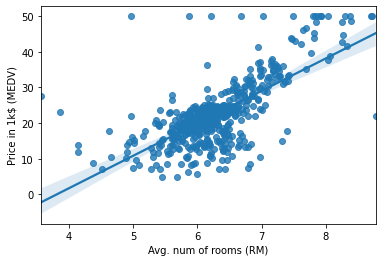

In [19]:
sns.regplot(data = df, x = 'RM', y = 'MEDV')
plt.xlabel('Avg. num of rooms (RM)')
plt.ylabel('Price in 1k$ (MEDV)')
plt.show()

----
#### 2. RANSAC (Random Sample Consensus)
- 회귀모델 훈련시 outlier 제거가 중요하다. 
- RANSAC 알고리즘은 정상치(inlier) 데이터를 반복적으로 추려내고 학습함으로써, outlier가 있어도(제거하지 않아도) 안정적인 성능을 낸다. 
----

In [30]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials = 100,          ## 최대반복횟수
                         min_samples = 50,          ## 랜덤하게 선택할 샘플의 갯수 
                         loss = 'absolute_error',   ## 절대값을 기준으로 학습 
                         residual_threshold = 5.0,  ## 회귀선과 샘플간 거리 5이내인 것을 inlier로 간주 
                         random_state = 42 )

ransac.fit(X, y)
print('절편: %.3f' % ransac.estimator_.intercept_)
print('기울기: %.3f' % ransac.estimator_.coef_[0])

절편: -36.493
기울기: 9.520


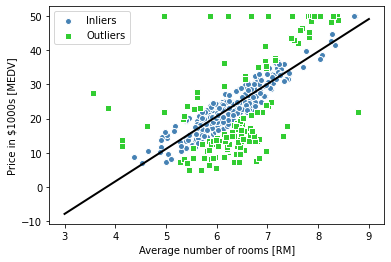

In [31]:
## 참고 
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

# plt.savefig('images/10_08.png', dpi=300)
plt.show()

---
#### 3. 회귀모델 성능평가 
- 잔차곡선(residual plot) : 오차가 랜덤하게 분포되고 잔차는 중앙을 중심으로 랜덤해야 함 
- 평균제곱오차 (MSE) : 오차제곱의 평균값 
- 결정계수 (R^2) : 타깃의 분산에서 모델이 잡아낸 비율, MSE의 표준화 버전 
---

In [32]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
slr = LinearRegression()
slr.fit(X_train, y_train)

print('-train accuracy =', slr.score(X_train, y_train))
print('-test accuracy =', slr.score(X_test, y_test))

-train accuracy = 0.7434997532004697
-test accuracy = 0.7112260057484973


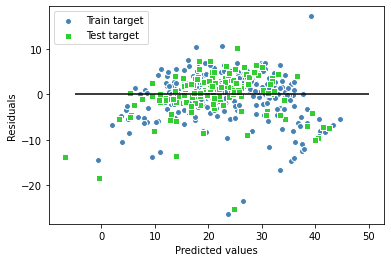

In [41]:
## residual plot 
y_train_pred = slr.predict(X_train) 
y_test_pred = slr.predict(X_test)

plt.scatter(y_train_pred, y_train_pred - y_train, 
            c = 'steelblue', marker = 'o', edgecolor = 'white', 
            label = 'Train target' )

plt.scatter(y_test_pred, y_test_pred - y_test, 
            c = 'limegreen', marker = 's', edgecolor = 'white', 
            label = 'Test target' )

plt.hlines(y=0, xmin=-np.min(y_test), xmax=np.max(y_test) , color = 'black')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

- 잔차의 분포에서 어떤 패턴이 나타나면, 어떤 정보를 잡아내지 못했다 --> 잔차가 새어 나갔다고 판단한다. (우측 하단에 그런 부분이 보인다.)

In [43]:
## MSE (Mean Squared Error)
from sklearn.metrics import mean_squared_error 

print('-train MSE =', mean_squared_error(y_train, y_train_pred))
print('-test MES =', mean_squared_error(y_test, y_test_pred))

-train MSE = 22.545481487421426
-test MES = 21.51744423117691


In [44]:
## R^2 
from sklearn.metrics import r2_score

print('-train R2 =', r2_score(y_train, y_train_pred))
print('-test R2 =', r2_score(y_test, y_test_pred))

-train R2 = 0.7434997532004697
-test R2 = 0.7112260057484973


----
#### 4. Multiple Regression 
- 비선형 관계인 MEDV(주택가격)과 LSTAT(저소득층 비율)간의 관계 분석 
----

<AxesSubplot:xlabel='LSTAT', ylabel='MEDV'>

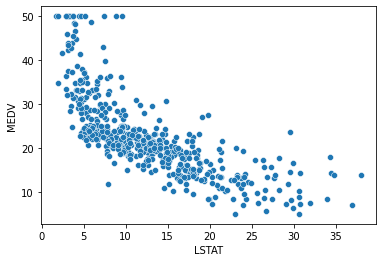

In [45]:
sns.scatterplot(data=df, x='LSTAT', y='MEDV')

In [51]:
## PolynomialFeatures를 사용하여, 2차 & 3차 방정식을 만들고 예측성능 비교 
from sklearn.preprocessing import PolynomialFeatures
X = df[['LSTAT']].values
y = df['MEDV'].values

## 1,2,3차 방정식 
regr = LinearRegression()

quadratic = PolynomialFeatures(degree = 2)
X_quad = quadratic.fit_transform(X)

cubic = PolynomialFeatures(degree = 3)
X_cubic = cubic.fit_transform(X)

## 훈련 & 성능평가 
regr.fit(X, y)
print('- R Score of 1차방정식 :', r2_score(y, regr.predict(X)))

regr.fit(X_quad, y)
print('- R Score of 2차방정식 :', r2_score(y, regr.predict(X_quad)))

regr.fit(X_cubic, y)
print('- R Score of 3차방정식 :', r2_score(y, regr.predict(X_cubic)))

- R Score of 1차방정식 : 0.5441462975864799
- R Score of 2차방정식 : 0.6407168971636612
- R Score of 3차방정식 : 0.657847640589572


- 1> 2> 3차 방정식으로 갈수록 모형의 성능이 개선되었음 
- 단 LSTAT와 MEDV의 산포도를 보니, 이러한 경우는 로그변환을 하면 좋을 듯 함 (y = -x^2과 유사해 보이므로)

In [54]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

regr = regr.fit(X_log, y_sqrt)
r2_score(y_sqrt, regr.predict(X_log))
print('- R Score of log-square 변환 :', r2_score(y_sqrt, regr.predict(X_log)))

- R Score of log-square 변환 : 0.6909284798971007


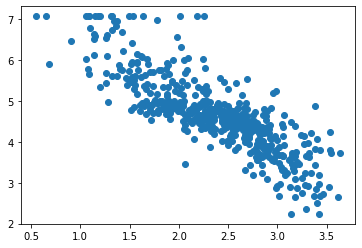

In [55]:
plt.scatter(X_log, y_sqrt)

---
#### 4. Random Forest Regression 
- Decision Tree를 앙상블한 랜덤포레스트는, 개별 선형함수의 합 
- 즉 입력공간을 학습하기 좋은 더 작은 여러개의 공간으로 분할하여 학습하는 개념 
- outlier에 덜 민감하고, 파라미터 튜닝 노력이 적게 든다 (ex. 표준화 불필요). 일반적으로 트리 depth만 지정해주면 됨 
---

In [57]:
X = df.iloc[:, :-1].values 
y = df['MEDV'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(n_estimators = 1000, 
                               criterion = 'squared_error', 
                               n_jobs = -1, random_state = 42 )
forest.fit(X_train, y_train) 
print('-Train score =', forest.score(X_train, y_train))
print('-Test score =', forest.score(X_test, y_test))

-Train score = 0.9751737143619665
-Test score = 0.8599457668589674


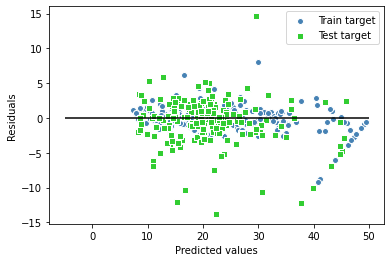

In [59]:
## residual plot 
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

plt.scatter(y_train_pred, y_train_pred - y_train, 
            c = 'steelblue', marker = 'o', edgecolor = 'white', 
            label = 'Train target' )

plt.scatter(y_test_pred, y_test_pred - y_test, 
            c = 'limegreen', marker = 's', edgecolor = 'white', 
            label = 'Test target' )

plt.hlines(y=0, xmin=-np.min(y_test), xmax=np.max(y_test) , color = 'black')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

- 이전 residual plot에 비해 개선되었다. 